In [106]:
# import libraries
import polars as pl
import urllib.request
import os
from pathlib import Path
from datetime import datetime, timedelta
import hvplot.polars
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [107]:
# load CSV
notebook_dir = Path.cwd()
file_path = notebook_dir.parent / "data" / "external" / "FPA_FOD_Plus.csv"

df = pl.read_csv(file_path, infer_schema_length=10000, ignore_errors=True)

# convert DISCOVERY_DATE to datetime
df = df.with_columns(
    pl.col("DISCOVERY_DATE").str.strptime(pl.Date, "%Y-%m-%d").alias("DISCOVERY_DATE")
)

print(df.select("DISCOVERY_DATE").head())
print(f"The number of columns in the dataset: {df.shape[1]}")
print(f"The number of rows in the dataset: {df.shape[0]}")


shape: (5, 1)
┌────────────────┐
│ DISCOVERY_DATE │
│ ---            │
│ date           │
╞════════════════╡
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
│ 2007-01-01     │
└────────────────┘
The number of columns in the dataset: 308
The number of rows in the dataset: 2302521


In [108]:
# replicating what Shanti did with dropping columns that have missing values greater than 80%
# praciting polars so replicating using that library instead of pandas
# total number of rows
n_rows = df.height

# threshold: 80% of rows missing
cutoff_missing_values = 0.8 * n_rows

# calculate missing values per column
missing_counts = {col: df.select(pl.col(col).is_null().sum()).to_numpy()[0][0] for col in df.columns}

# sort columns by number of missing values (descending)
missing_counts_sorted = dict(sorted(missing_counts.items(), key=lambda item: item[1], reverse=True))

# columns to drop: missing values > 80% of rows
cols_missing_gt80pct = [col for col, miss_count in missing_counts_sorted.items() if miss_count > cutoff_missing_values]

df = df.drop(cols_missing_gt80pct)

print(f"Dropped columns: {len(cols_missing_gt80pct)}")
print(f"Total columns after dropping: {len(df.columns)}")
print(f"Column names int the dataset: {list(df.columns)}")


Dropped columns: 24
Total columns after dropping: 284
Column names int the dataset: ['FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'LatLong_State', 'LatLong_County', 'NPL', 'Mang_Type', 'Mang_Name', 'Des_Tp', 'GAP_Sts', 'GAP_Prity', 'EVH', 'EVT', 'EVH_1km', 'EVT_1km', 'EVC', 'EVC_1km', 'NAME', 'MOD_NDVI_12m', 'MOD_EVI_12m', 'Land_Cover', 'Land_Cover_1km', 'rpms', 'rpms_1km', 'Population', 'Popo_1km', 'GACCAbbrev', 'GACC_PL', 'GACC_New fire', 'GACC_Type 1 IMTs', 'GACC_Type 2 IMTs', 'GACC_NIMO Teams', 'GACC_Area Command

In [109]:
# descriptive stats
print("Data types:")
print(df.select(['FIRE_SIZE_CLASS', 'FIRE_SIZE']).dtypes)

print("\nDescriptive statistics for FIRE_SIZE:")
print(df.select('FIRE_SIZE').describe())

# counts per FIRE_SIZE_CLASS using value_counts()
print("\nCounts per FIRE_SIZE_CLASS:")
print(df['FIRE_SIZE_CLASS'].value_counts(sort=True))

# missing values
missing_summary = df.select([
    pl.col('FIRE_SIZE_CLASS').is_null().sum().alias('FIRE_SIZE_CLASS_missing'),
    pl.col('FIRE_SIZE').is_null().sum().alias('FIRE_SIZE_missing')
])
print("\nMissing values summary:")
print(missing_summary)

# percentiles
percentiles = df.select([
    pl.col('FIRE_SIZE').quantile(0.25).alias('25%'),
    pl.col('FIRE_SIZE').quantile(0.5).alias('50% (median)'),
    pl.col('FIRE_SIZE').quantile(0.75).alias('75%'),
    pl.col('FIRE_SIZE').quantile(0.95).alias('95%'),
    pl.col('FIRE_SIZE').quantile(0.99).alias('99%')
])
print("\nFIRE_SIZE percentiles:")
print(percentiles)


Data types:
[String, Float64]

Descriptive statistics for FIRE_SIZE:
shape: (9, 2)
┌────────────┬─────────────┐
│ statistic  ┆ FIRE_SIZE   │
│ ---        ┆ ---         │
│ str        ┆ f64         │
╞════════════╪═════════════╡
│ count      ┆ 2.302521e6  │
│ null_count ┆ 0.0         │
│ mean       ┆ 78.178024   │
│ std        ┆ 2631.076669 │
│ min        ┆ 0.00001     │
│ 25%        ┆ 0.1         │
│ 50%        ┆ 0.8         │
│ 75%        ┆ 3.0         │
│ max        ┆ 662700.0    │
└────────────┴─────────────┘

Counts per FIRE_SIZE_CLASS:
shape: (7, 2)
┌─────────────────┬─────────┐
│ FIRE_SIZE_CLASS ┆ count   │
│ ---             ┆ ---     │
│ str             ┆ u32     │
╞═════════════════╪═════════╡
│ B               ┆ 1103730 │
│ A               ┆ 876238  │
│ C               ┆ 256879  │
│ D               ┆ 34003   │
│ E               ┆ 17193   │
│ F               ┆ 9694    │
│ G               ┆ 4784    │
└─────────────────┴─────────┘

Missing values summary:
shape: (1, 2)
┌─────────

/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_83935/3795587966.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


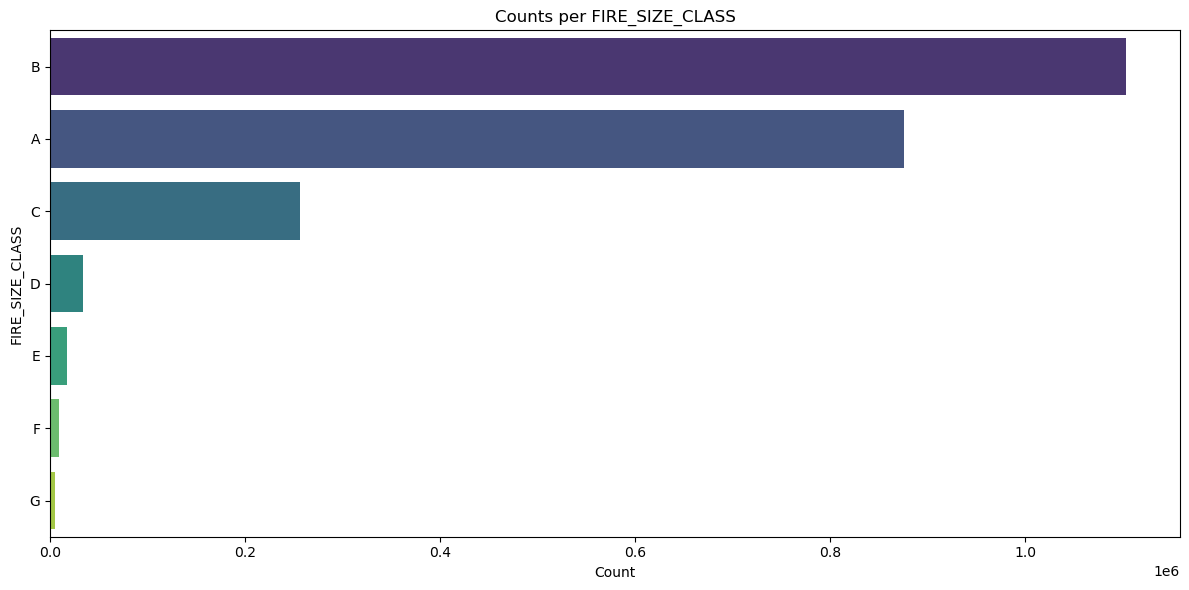

/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_83935/3795587966.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


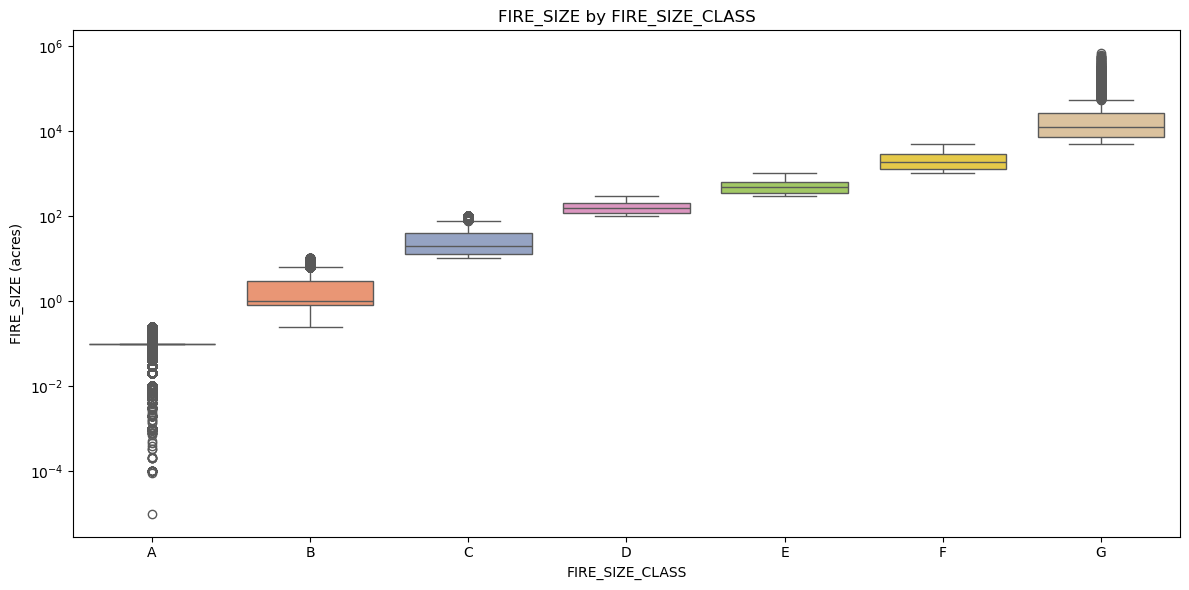

In [110]:
df_plot = df.select(['FIRE_SIZE_CLASS', 'FIRE_SIZE']).to_pandas()

# countplot for FIRE_SIZE_CLASS (categorical)
plt.figure(figsize=(12,6))
sns.countplot(
    data=df_plot,
    y='FIRE_SIZE_CLASS',
    order=df_plot['FIRE_SIZE_CLASS'].value_counts().index,
    palette='viridis'
)
plt.title('Counts per FIRE_SIZE_CLASS')
plt.xlabel('Count')
plt.ylabel('FIRE_SIZE_CLASS')
plt.tight_layout()
plt.show()

# boxplot of FIRE_SIZE by FIRE_SIZE_CLASS
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_plot,
    x='FIRE_SIZE_CLASS',
    y='FIRE_SIZE',
    palette='Set2'
)
plt.title('FIRE_SIZE by FIRE_SIZE_CLASS')
plt.xlabel('FIRE_SIZE_CLASS')
plt.ylabel('FIRE_SIZE (acres)')
plt.yscale('log')  # optional
plt.tight_layout()
plt.show()

In [111]:
# convert FIRE_SIZE to pandas for easy pd.cut
df_binned = df.select("FIRE_SIZE").to_pandas()

#  bins based on fire classes (adjustable)
bins = [0, 100, 4999, 29000, df_large_pd["FIRE_SIZE"].max()]
labels = ["Small", "Medium", "Large", "Very Large"]

fire_bins = pd.cut(df_binned["FIRE_SIZE"], bins=bins, labels=labels, include_lowest=True)

print(fire_bins.value_counts().reindex(labels))
print(fire_bins.value_counts(normalize=True).reindex(labels))


FIRE_SIZE
Small         2241807
Medium          55930
Large            3682
Very Large       1102
Name: count, dtype: int64
FIRE_SIZE
Small         0.973632
Medium        0.024291
Large         0.001599
Very Large    0.000479
Name: proportion, dtype: float64


In [112]:
# Keep fires >= 100 acres, but cap nothing above
df_large = df.filter(pl.col("FIRE_SIZE") >= 100)
df_large_pd = df_large.select(['FIRE_SIZE']).to_pandas()

quantiles = df_large_pd["FIRE_SIZE"].quantile([0, 0.25, 0.5, 0.75])
bins = quantiles.tolist() + [700_000]  # Top bin capped at 700k
labels = ["Medium", "Large", "Very Large", "Extreme"]

df_large_pd['fire_size_bin'] = pd.cut(
    df_large_pd["FIRE_SIZE"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# add a column with the numeric range for each bin
bin_ranges = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]
range_mapping = dict(zip(labels, bin_ranges))
df_large_pd['fire_size_range'] = df_large_pd['fire_size_bin'].map(range_mapping)

summary = df_large_pd.groupby(['fire_size_bin', 'fire_size_range']).size().reset_index(name='count')
summary['percent'] = (summary['count'] / summary['count'].sum() * 100).round(2)
# only keep rows with non-zero counts
summary_clean = summary[summary['count'] > 0].reset_index(drop=True)
print(summary_clean)


  fire_size_bin fire_size_range  count  percent
0        Medium         100-150  18035    27.46
1         Large         150-275  14832    22.58
2    Very Large         275-800  16712    25.45
3       Extreme      800-700000  16095    24.51


/var/folders/3d/thk4g7jj4d52ms21t3_17w_h0000gn/T/ipykernel_83935/1164519870.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_large_pd.groupby(['fire_size_bin', 'fire_size_range']).size().reset_index(name='count')


In [113]:
# Group chose to go with the small, medium, large, very large approach above
